In [3]:
!python3.12 -m pip install scipy

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

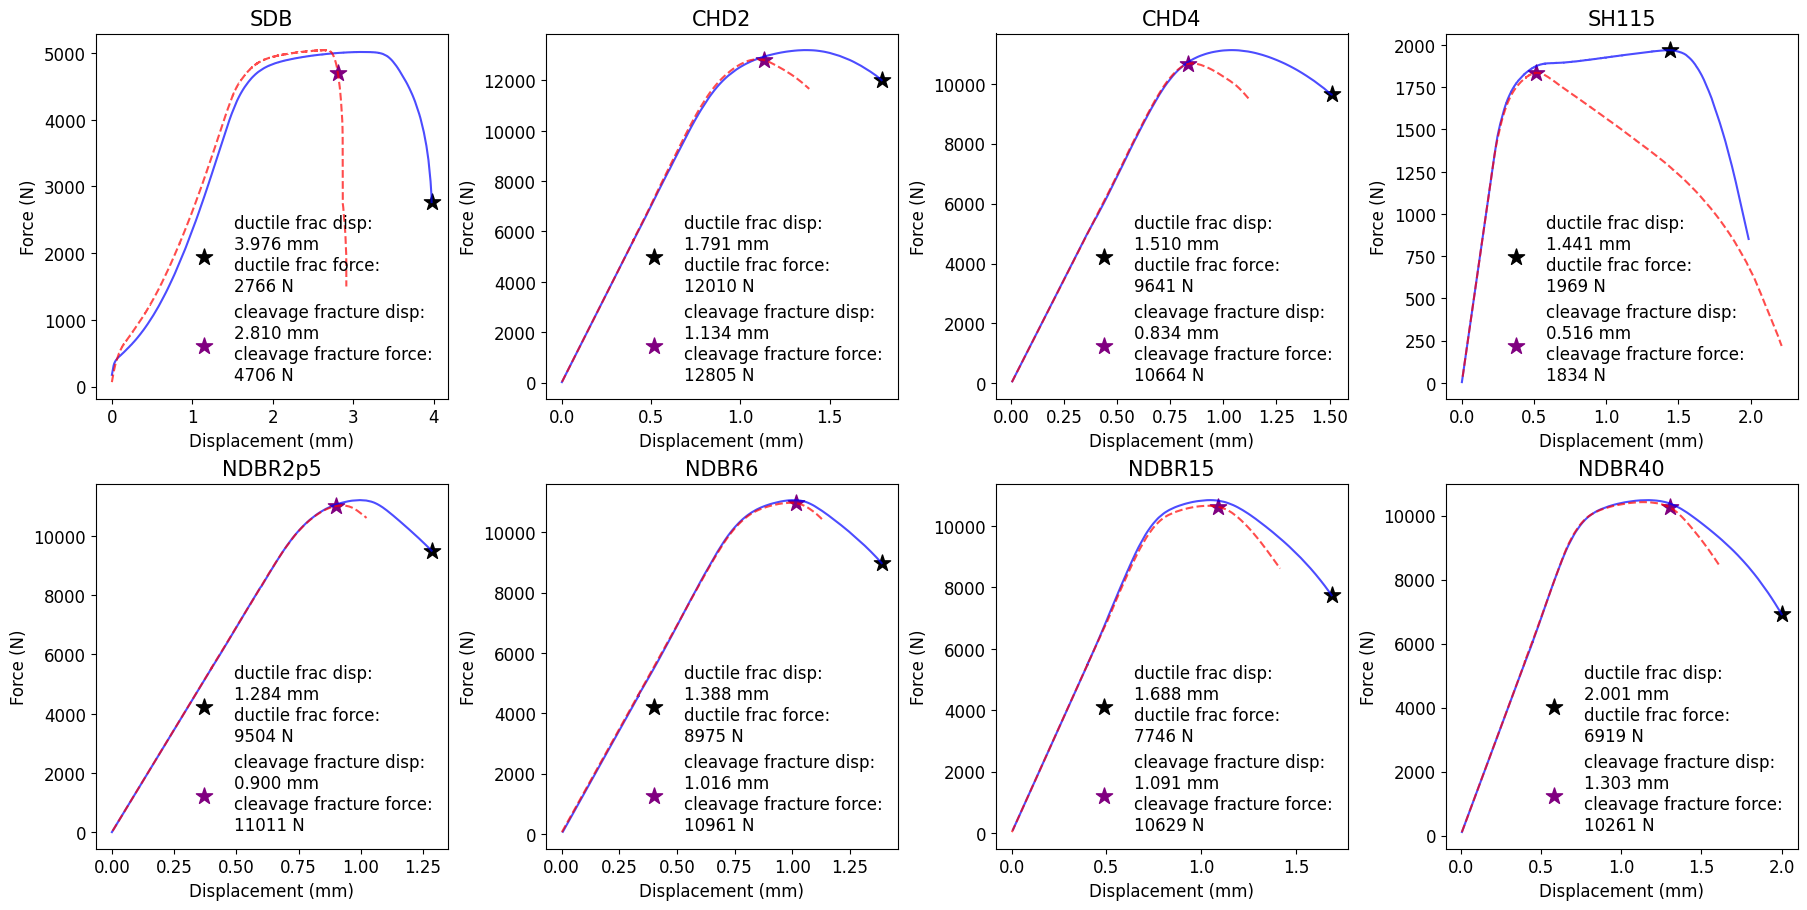

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 9))
# tight layout
# Adjusting layout with padding to avoid overlap
plt.tight_layout(pad=2.0, h_pad=4.0, w_pad=4.0)
ax = ax.ravel()

fontsize=12

geometries = ["SDB", "CHD2", "CHD4","SH115", "NDBR2p5", "NDBR6", "NDBR15", "NDBR40", ]

# We add 8 columns to store the information of each geometry

columns = ["geometry", "UTS_disp_without_HE", "UTS_force_without_HE", "frac_disp_without_HE", "frac_force_without_HE",
                    "UTS_disp_with_HE", "UTS_force_with_HE", "frac_disp_with_HE", "frac_force_with_HE", "work_done_without_HE", "work_done_with_HE"]

df_info = pd.DataFrame(columns=columns)

df_info["geometry"] = geometries


for i, objective in enumerate(geometries):
    FD_curve_without_HE = pd.read_excel(f"experiment_FD_curve/{objective}_without_HE.xlsx")
    FD_curve_with_HE = pd.read_excel(f"experiment_FD_curve/{objective}_with_HE.xlsx")
    disp_without_HE = FD_curve_without_HE["displacement/mm"]
    force_without_HE = FD_curve_without_HE["force/N"]
    disp_with_HE = FD_curve_with_HE["displacement/mm"]
    force_with_HE = FD_curve_with_HE["force/N"]

    # Now we determine the displacement value for both case: 1) at fracture, 2) at UTS
    # 1) Without Hydrogen
    frac_disp_without_HE = disp_without_HE.iloc[-1]
    frac_force_without_HE = force_without_HE.iloc[-1]
    UTS_force_without_HE = force_without_HE.max()
    UTS_disp_without_HE = disp_without_HE.iloc[np.argmax(force_without_HE)]
    
    # 2) With Hydrogen

    # Now, the definition of UTS in with Hydrogen is a little bit different
    # It will be the point where it starts to deviate from the without hydrogen charging case.
    # We can set a threshold of x N difference between the two curves to determine the UTS point

    def find_differing_disp(disp_without_HE, force_without_HE, disp_with_HE, force_with_HE, threshold=10):
        from scipy import interpolate
        f = interpolate.interp1d(disp_without_HE, force_without_HE, fill_value='extrapolate')
        interpolated_force_without_HE = f(disp_with_HE)
        differing_disp = disp_with_HE[0]
        differing_force = force_with_HE[0]
        for i in range(len(interpolated_force_without_HE)):
            if abs(interpolated_force_without_HE[i] - force_with_HE[i]) > threshold:
                differing_disp = disp_with_HE[i]
                differing_force = force_with_HE[i]
                break
        # Now find the force at this point
        return differing_disp, differing_force

    frac_disp_with_HE = disp_with_HE.iloc[-1]
    frac_force_with_HE = force_with_HE.iloc[-1]

    force_diff_threshold = {
        "SDB": 295,
        "CHD2": 143,
        "CHD4": 60,
        "NDBR2p5": 50,
        "NDBR6": 100,
        "NDBR15": 200,
        "NDBR40": 120,
        "SH115": 40
    }

    threshold = force_diff_threshold[objective]
    # UTS_force_with_HE = force_with_HE.max()
    # UTS_disp_with_HE = disp_with_HE.iloc[np.argmax(force_with_HE)]
    UTS_disp_with_HE, UTS_force_with_HE = find_differing_disp(disp_without_HE.to_numpy(), force_without_HE.to_numpy(), 
                                        disp_with_HE.to_numpy(), force_with_HE.to_numpy(), threshold=threshold)

    df_info.loc[df_info["geometry"] == objective, "UTS_disp_without_HE"] = UTS_disp_without_HE
    df_info.loc[df_info["geometry"] == objective, "UTS_force_without_HE"] = UTS_force_without_HE
    df_info.loc[df_info["geometry"] == objective, "frac_disp_without_HE"] = frac_disp_without_HE
    df_info.loc[df_info["geometry"] == objective, "frac_force_without_HE"] = frac_force_without_HE

    df_info.loc[df_info["geometry"] == objective, "UTS_disp_with_HE"] = UTS_disp_with_HE
    df_info.loc[df_info["geometry"] == objective, "UTS_force_with_HE"] = UTS_force_with_HE
    df_info.loc[df_info["geometry"] == objective, "frac_disp_with_HE"] = frac_disp_with_HE
    df_info.loc[df_info["geometry"] == objective, "frac_force_with_HE"] = frac_force_with_HE

    
    # from scipy.integrate import simps

    # # Assuming 'force' and 'displacement' are the two arrays
    # work_done_without_HE = simps(force_without_HE, disp_without_HE)
    # wor_done_with_HE = simps(force_with_HE, disp_with_HE)

    # df_info.loc[df_info["geometry"] == objective, "work_done_without_HE"] = work_done_without_HE
    # df_info.loc[df_info["geometry"] == objective, "work_done_with_HE"] = wor_done_with_HE
    
    markersize = 150
    # ax[i].scatter(UTS_disp_without_HE, UTS_force_without_HE, marker=".", color="black", 
    #             label=f"UTS disp: {UTS_disp_without_HE:.3f} mm\nUTS force: {UTS_force_without_HE:.0f} N", s=markersize)
    if objective != "SH115":
        ax[i].scatter(frac_disp_without_HE, frac_force_without_HE, marker="*", color="black", 
                    label=f"ductile frac disp:\n{frac_disp_without_HE:.3f} mm\nductile frac force:\n{frac_force_without_HE:.0f} N", s=markersize)
    else:
        ax[i].scatter(UTS_disp_without_HE, UTS_force_without_HE, marker="*", color="black", 
                    label=f"ductile frac disp:\n{UTS_disp_without_HE:.3f} mm\nductile frac force:\n{UTS_force_without_HE:.0f} N", s=markersize)

    # ax[i].scatter(UTS_disp_with_HE, UTS_force_with_HE, marker=".", color="purple",
    #             label=f"UTS disp: {UTS_disp_with_HE:.3f} mm\nUTS force: {UTS_force_with_HE:.0f} N", s=markersize)
    # ax[i].scatter(frac_disp_with_HE, frac_force_with_HE, marker="*", color="purple",
    #             label=f"frac disp: {frac_disp_with_HE:.3f} mm\nfrac force: {frac_force_with_HE:.0f} N", s=markersize)

    ax[i].scatter(UTS_disp_with_HE, UTS_force_with_HE, marker="*", color="purple",
                label=f"cleavage fracture disp:\n{UTS_disp_with_HE:.3f} mm\ncleavage fracture force:\n{UTS_force_with_HE:.0f} N", s=markersize)


    ax[i].plot(disp_without_HE, force_without_HE, color="blue", alpha=0.7)
    ax[i].plot(disp_with_HE, force_with_HE, color="red", linestyle="--", alpha=0.7)


    ax[i].set_title(objective, fontsize=fontsize+3)
    if objective == "SH115":
        ax[i].legend(frameon=False, loc="lower center", fontsize=fontsize)
    else:
        ax[i].legend(frameon=False, loc=4, fontsize=fontsize)
    ax[i].set_xlabel("Displacement (mm)", fontsize=fontsize)
    ax[i].set_ylabel("Force (N)", fontsize=fontsize)
    # set ticks size
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)

# ax[7].axis("off")
# ax[7].plot([], [], label="without Hydrogen charging", color="blue")
# ax[7].plot([], [], label="with Hydrogen charging", color="red", linestyle="--")
# ax[7].legend(frameon=False, loc="center", fontsize=fontsize+3)

# df_info.to_excel("summary.xlsx", index=False)

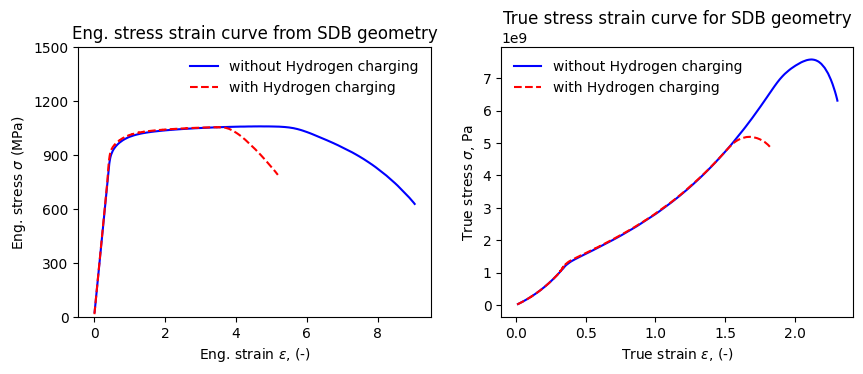

In [62]:
import numpy as np
import pandas as pd

# Load the experimental data for the SDB geometry without HE
# Given parameters
E = 210e9  # Young's modulus in Pa
nu = 0.3  # Poisson's ratio
thickness = 1e-3  # Thickness in meters (1 mm)
width = 5e-3  # Width in meters (5 mm)
cross_section_area = thickness * width  # Cross-sectional area in m²

SDB_without_HE_stress_strain = pd.read_excel("experiment_FD_curve/SDB_without_HE_stress_strain.xlsx")
SDB_with_HE_stress_strain = pd.read_excel("experiment_FD_curve/SDB_with_HE_stress_strain.xlsx")

eng_strain_without_HE = SDB_without_HE_stress_strain["strain/-"]
eng_stress_without_HE = SDB_without_HE_stress_strain["stress/Pa"]
eng_strain_with_HE = SDB_with_HE_stress_strain["strain/-"]
eng_stress_with_HE = SDB_with_HE_stress_strain["stress/Pa"]

# plot subplot of 2 x 1 grid
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
ax = ax.ravel()
ax[0].plot(eng_strain_without_HE, eng_stress_without_HE / 1e6, label="without Hydrogen charging", color="blue")
ax[0].plot(eng_strain_with_HE, eng_stress_with_HE / 1e6, label="with Hydrogen charging", color="red", linestyle="--")
ax[0].set_xlabel(r"Eng. strain $\varepsilon$, (-)")
ax[0].set_ylabel(r"Eng. stress $\sigma$ (MPa)")
ax[0].set_title("Eng. stress strain curve from SDB geometry")
ax[0].set_ylim(0, 1500)
ax[0].set_yticks(np.arange(0, 1501, 300))
ax[0].legend(frameon=False)

# calculate true stress true strain
true_strain_without_HE = np.log(1 + eng_strain_without_HE)
true_stress_without_HE = eng_stress_without_HE * (1 + eng_strain_without_HE)
true_strain_with_HE = np.log(1 + eng_strain_with_HE)
true_stress_with_HE = eng_stress_with_HE * (1 + eng_strain_with_HE)

ax[1].plot(true_strain_without_HE, true_stress_without_HE, label="without Hydrogen charging", color="blue")
ax[1].plot(true_strain_with_HE, true_stress_with_HE, label="with Hydrogen charging", color="red", linestyle="--")
ax[1].set_xlabel(r"True strain $\varepsilon$, (-)")
ax[1].set_ylabel(r"True stress $\sigma$, Pa")
ax[1].set_title("True stress strain curve for SDB geometry")
ax[1].legend(frameon=False)
plt.show()



0       0.000123
1       0.000125
2       0.000128
3       0.000132
4       0.000136
          ...   
6535    0.003053
6536    0.003042
6537    0.003029
6538    0.003015
6539    0.002989
Name: stress/Pa, Length: 6540, dtype: float64


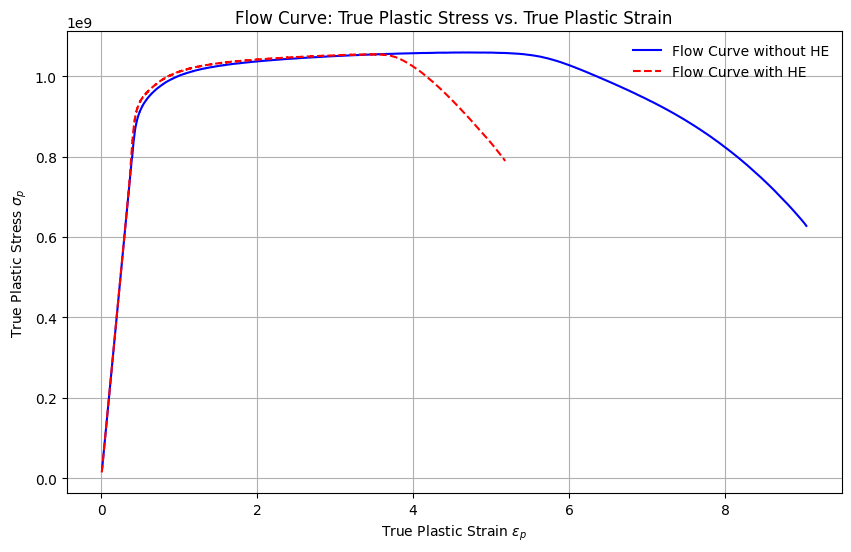

In [52]:
true_strain_without_HE = eng_strain_without_HE
true_stress_without_HE = eng_stress_without_HE
true_strain_with_HE = eng_strain_with_HE
true_stress_with_HE = eng_stress_with_HE

# Elastic strain calculation for both cases
true_elastic_strain_without_HE = true_stress_without_HE / E
print(true_elastic_strain_without_HE)
true_elastic_strain_with_HE = true_stress_with_HE / E

# True plastic strain = True strain - Elastic strain
true_plastic_strain_without_HE = true_strain_without_HE - true_elastic_strain_without_HE
true_plastic_strain_with_HE = true_strain_with_HE - true_elastic_strain_with_HE

# True plastic stress is the same as true stress for the flow curve
true_plastic_stress_without_HE = true_stress_without_HE.copy()
true_plastic_stress_with_HE = true_stress_with_HE.copy()

# Plot the flow curves
plt.figure(figsize=(10, 6))
plt.plot(true_plastic_strain_without_HE, true_plastic_stress_without_HE, label="Flow Curve without HE", color="blue")
plt.plot(true_plastic_strain_with_HE, true_plastic_stress_with_HE, label="Flow Curve with HE", color="red", linestyle="--")
plt.xlabel(r"True Plastic Strain $\varepsilon_p$")
plt.ylabel(r"True Plastic Stress $\sigma_p$")
plt.title("Flow Curve: True Plastic Stress vs. True Plastic Strain")
plt.legend(frameon=False)
plt.grid(True)
plt.show()

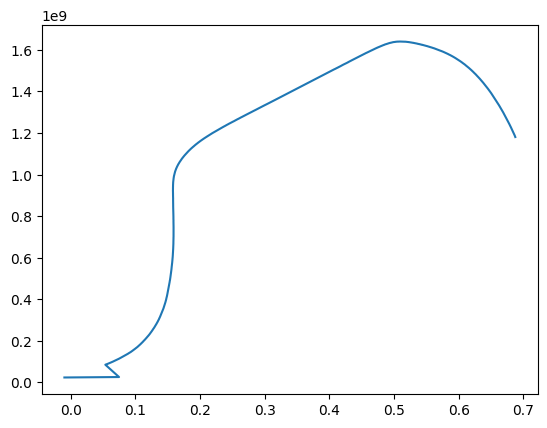

In [28]:
# Calculate true stress and true strain
true_stress = engineering_stress * (1 + engineering_strain)  # True stress = Engineering stress * (1 + Engineering strain)
true_strain = np.log(1 + engineering_strain)  # True strain = ln(1 + Engineering strain)

# Calculate true plastic strain using additive strain formula
true_elastic_strain = true_stress / E  # Elastic strain = Stress / Young's modulus
true_plastic_strain = true_strain - true_elastic_strain  # Plastic strain = Total strain - Elastic strain

# True plastic stress is typically taken to be the same as true stress for the flow curve
true_plastic_stress = true_stress.copy()  # Flow curve relates true plastic strain to true stress

plt.plot(true_plastic_strain, true_plastic_stress)

In [18]:
# Define the geometries
geometries = ["CHD2", "CHD4", "NDBR2p5", "NDBR6", "NDBR15", "NDBR40", "SH115"]

# Define the columns for the result dataframe
columns = ["geometry", "UTS_without_H (N)", "UTS_with_H (N)", "Ductility_without_H (mm)", "Ductility_with_H (mm)", 
           "Reduction_UTS (%)", "Reduction_Ductility (%)"]

# Initialize the dataframe to store results
df_summary = pd.DataFrame(columns=columns)

# Loop through each geometry to process the data
for geometry in geometries:
    # Load data for without hydrogen charging
    FD_curve_without_H = pd.read_excel(f"experiment_FD_curve/{geometry}_without_HE.xlsx")
    FD_curve_with_H = pd.read_excel(f"experiment_FD_curve/{geometry}_with_HE.xlsx")
    
    # Extract displacement and force for both cases
    disp_without_H = FD_curve_without_H["displacement/mm"]
    force_without_H = FD_curve_without_H["force/N"]
    disp_with_H = FD_curve_with_H["displacement/mm"]
    force_with_H = FD_curve_with_H["force/N"]
    
    # UTS: Maximum force
    UTS_without_H = force_without_H.max()
    UTS_with_H = force_with_H.max()
    
    # Ductility: Last displacement point
    Ductility_without_H = disp_without_H.iloc[-1]
    Ductility_with_H = disp_with_H.iloc[-1]
    
    # Calculate reductions
    Reduction_UTS = ((UTS_without_H - UTS_with_H) / UTS_without_H) * 100
    Reduction_Ductility = ((Ductility_without_H - Ductility_with_H) / Ductility_without_H) * 100
    
    # Append the results for the current geometry
    new_row = {
        "geometry": geometry,
        "UTS_without_H (N)": UTS_without_H,
        "UTS_with_H (N)": UTS_with_H,
        "Ductility_without_H (mm)": Ductility_without_H,
        "Ductility_with_H (mm)": Ductility_with_H,
        "Reduction_UTS (%)": Reduction_UTS,
        "Reduction_Ductility (%)": Reduction_Ductility
    }
    df_summary.loc[len(df_summary)] = new_row

df_summary 

,geometry,UTS_without_H (N),UTS_with_H (N),Ductility_without_H (mm),Ductility_with_H (mm),Reduction_UTS (%),Reduction_Ductility (%)
0,CHD2,13204.426352,12841.199113,1.790778,1.385498,2.750799,22.631514
1,CHD4,11122.422411,10679.311883,1.509993,1.117981,3.983939,25.961216
2,NDBR2p5,11212.891941,11034.966562,1.284346,1.022954,1.586793,20.352161
3,NDBR6,11063.081063,10974.549141,1.387971,1.136025,0.800247,18.152096
4,NDBR15,10848.481995,10663.908461,1.688428,1.416414,1.701377,16.110505
5,NDBR40,10485.613874,10423.289079,2.000633,1.609110,0.594384,19.569958
6,SH115,1969.495343,1834.974774,1.984920,2.213162,6.830205,-11.498815


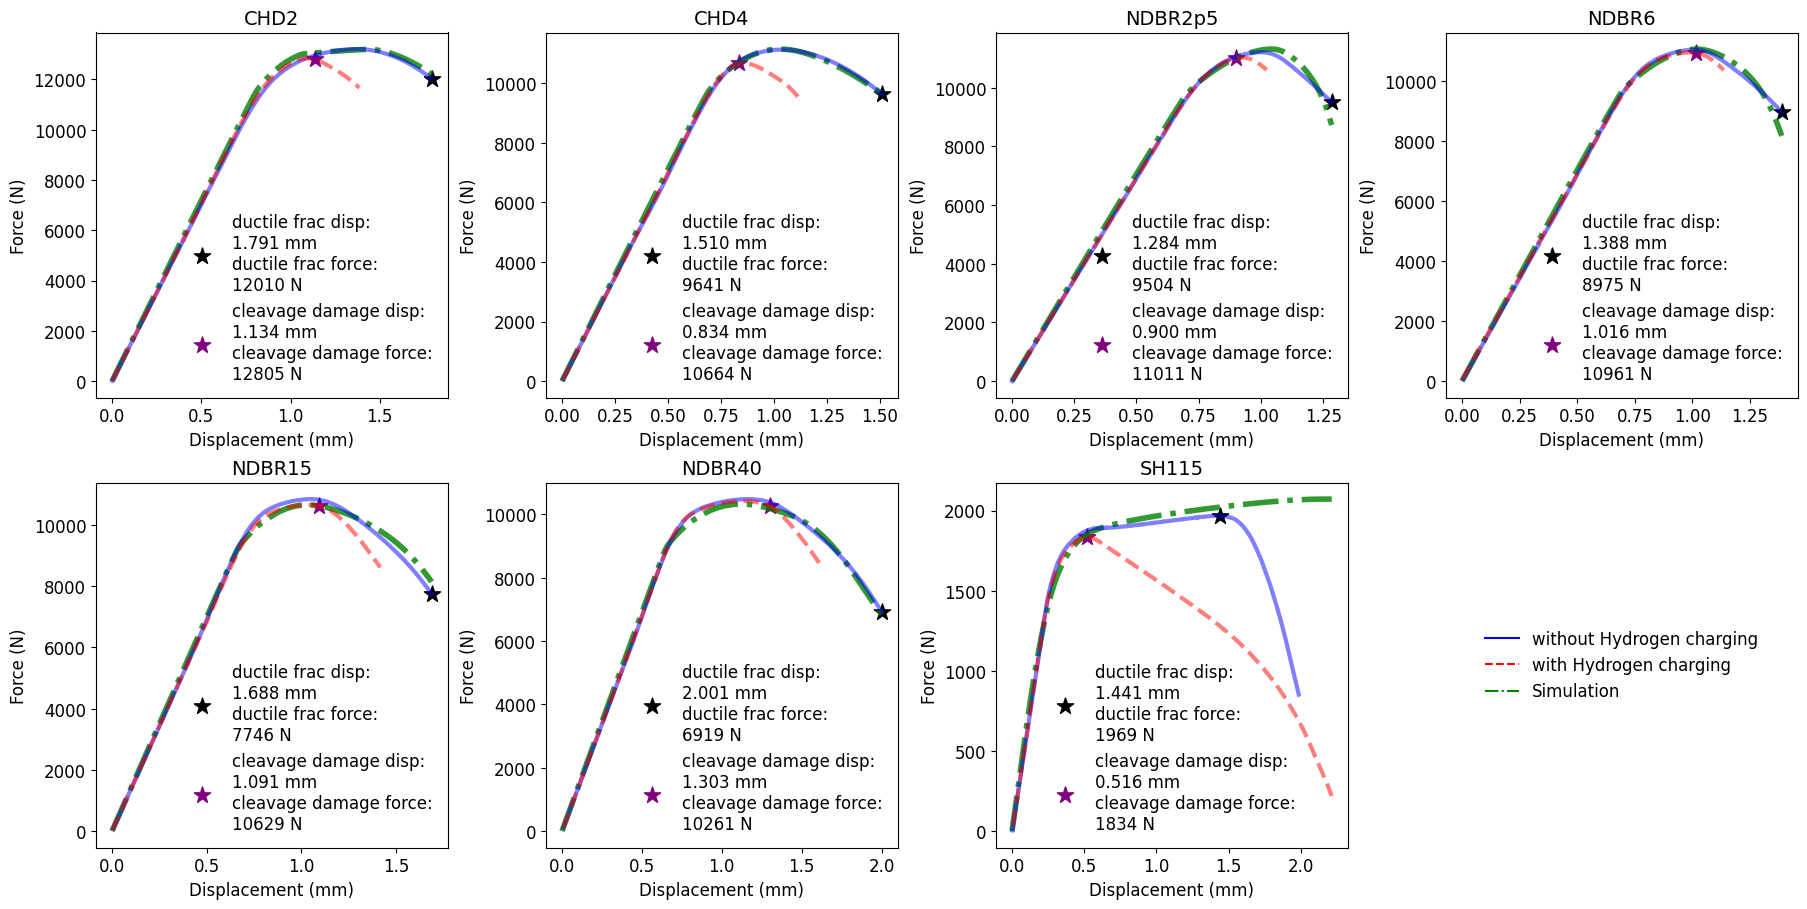

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 9))
# tight layout
# Adjusting layout with padding to avoid overlap
plt.tight_layout(pad=2.0, h_pad=4.0, w_pad=4.0)
ax = ax.ravel()

#geometries = ["NDBR2p5", "CHD2", "NDBR6", "CHD4","NDBR15", "SH115", "NDBR40", ]
geometries = ["CHD2", "CHD4", "NDBR2p5", "NDBR6", "NDBR15", "NDBR40", "SH115"]
fontsize = 12
linewidth = 3

def read_FD_curve(file_path):
    """
    Read the force-displacement curve from the .txt file from Abaqus output
    """
    output_data = np.loadtxt(file_path, skiprows=2)
    # column 1 is time step
    # column 2 is displacement
    # column 3 is force
    columns = ['X', 'displacement', 'force']
    df = pd.DataFrame(data=output_data, columns=columns)
    # Converting to numpy array
    displacement = df.iloc[:, 1].to_numpy()
    force = df.iloc[:, 2].to_numpy()
    return displacement, force

force_diff_threshold = {
    "SDB": 295,
    "CHD2": 143,
    "CHD4": 60,
    "NDBR2p5": 50,
    "NDBR6": 100,
    "NDBR15": 200,
    "NDBR40": 120,
    "SH115": 40
}

for i, objective in enumerate(geometries):
    FD_curve_without_HE = pd.read_excel(f"experiment_FD_curve/{objective}_without_HE.xlsx")
    FD_curve_with_HE = pd.read_excel(f"experiment_FD_curve/{objective}_with_HE.xlsx")
    
    disp_without_HE = FD_curve_without_HE["displacement/mm"]
    force_without_HE = FD_curve_without_HE["force/N"]
    disp_with_HE = FD_curve_with_HE["displacement/mm"]
    force_with_HE = FD_curve_with_HE["force/N"]

    # Now we determine the displacement value for both case: 1) at fracture, 2) at UTS
    # 1) At fracture
    frac_disp_without_HE = disp_without_HE.iloc[-1]
    frac_disp_with_HE = disp_with_HE.iloc[-1]
    frac_force_without_HE = force_without_HE.iloc[-1]
    frac_force_with_HE = force_with_HE.iloc[-1]
    # 2) At UTS. It occurs where force is max
    UTS_disp_without_HE = disp_without_HE.iloc[np.argmax(force_without_HE)]
    UTS_disp_with_HE = disp_with_HE.iloc[force_diff_threshold[objective]]
    UTS_force_without_HE = force_without_HE.max()
    UTS_force_with_HE = force_with_HE.iloc[force_diff_threshold[objective]]

    if os.path.exists(f"simulation_FD_curve/FD_curve_{objective}.txt"):
        disp_sim, force_sim = read_FD_curve(f"simulation_FD_curve/FD_curve_{objective}.txt")
        disp_sim = disp_sim * 1000
        ax[i].plot(disp_sim, force_sim, color="green", linestyle="-.", alpha=0.8, linewidth=linewidth+1)

    threshold = force_diff_threshold[objective]
    # UTS_force_with_HE = force_with_HE.max()
    # UTS_disp_with_HE = disp_with_HE.iloc[np.argmax(force_with_HE)]
    UTS_disp_with_HE, UTS_force_with_HE = find_differing_disp(disp_without_HE.to_numpy(), force_without_HE.to_numpy(), 
                                        disp_with_HE.to_numpy(), force_with_HE.to_numpy(), threshold=threshold)

    markersize = 150
    # ax[i].scatter(UTS_disp_without_HE, UTS_force_without_HE, marker=".", color="black", 
    #             label=f"UTS disp: {UTS_disp_without_HE:.3f} mm\nUTS force: {UTS_force_without_HE:.0f} N", s=markersize)
    if objective != "SH115":
        ax[i].scatter(frac_disp_without_HE, frac_force_without_HE, marker="*", color="black", 
                    label=f"ductile frac disp:\n{frac_disp_without_HE:.3f} mm\nductile frac force:\n{frac_force_without_HE:.0f} N", s=markersize)
    else:
        ax[i].scatter(UTS_disp_without_HE, UTS_force_without_HE, marker="*", color="black", 
                    label=f"ductile frac disp:\n{UTS_disp_without_HE:.3f} mm\nductile frac force:\n{UTS_force_without_HE:.0f} N", s=markersize)

    # ax[i].scatter(UTS_disp_with_HE, UTS_force_with_HE, marker=".", color="purple",
    #             label=f"UTS disp: {UTS_disp_with_HE:.3f} mm\nUTS force: {UTS_force_with_HE:.0f} N", s=markersize)
    # ax[i].scatter(frac_disp_with_HE, frac_force_with_HE, marker="*", color="purple",
    #             label=f"frac disp: {frac_disp_with_HE:.3f} mm\nfrac force: {frac_force_with_HE:.0f} N", s=markersize)

    ax[i].scatter(UTS_disp_with_HE, UTS_force_with_HE, marker="*", color="purple",
                label=f"cleavage damage disp:\n{UTS_disp_with_HE:.3f} mm\ncleavage damage force:\n{UTS_force_with_HE:.0f} N", s=markersize)


    ax[i].plot(disp_without_HE, force_without_HE, color="blue", alpha=0.5, linewidth=linewidth)
    ax[i].plot(disp_with_HE, force_with_HE, color="red", linestyle="--", alpha=0.5, linewidth=linewidth)


    # ax[i].plot([], [], label="without Hydrogen charging", color="blue")
    # ax[i].plot([], [], label="with Hydrogen charging", color="red", linestyle="--")
    # ax[i].plot([], [], label="Simulation", color="green", linestyle="-.")

    ax[i].set_title(objective, fontsize=fontsize+2)
    if objective == "SH115":
        ax[i].legend(frameon=False, loc="lower center", fontsize=fontsize)
    else:
        ax[i].legend(frameon=False, loc=4, fontsize=fontsize)
    ax[i].set_xlabel("Displacement (mm)", fontsize=fontsize)
    ax[i].set_ylabel("Force (N)", fontsize=fontsize)
    # set ticks size
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)

ax[7].axis("off")
ax[7].plot([], [], label="without Hydrogen charging", color="blue")
ax[7].plot([], [], label="with Hydrogen charging", color="red", linestyle="--")
ax[7].plot([], [], label="Simulation", color="green", linestyle="-.")
ax[7].legend(frameon=False, loc="center", fontsize=fontsize)

In [77]:


fontsize=12
linewidth = 3

# Initialize a DataFrame to store the results
geometry_names = ["CHD2",  "CHD4", "SH115",  "NDBR2p5", "NDBR6","NDBR15", "NDBR40"]
data_columns = [
    "UTS_no_HC_force",
    "UTS_with_HC_force",
    "UTS_force_reduction_percent",
    "Fracture_no_HC_disp",
    "Fracture_with_HC_disp",
    "Fracture_disp_reduction_percent",
]

# Create an empty dataframe
results_df = pd.DataFrame(columns=data_columns, index=geometry_names)

for i, objective in enumerate(geometries):
    FD_curve_without_HE = pd.read_excel(f"experiment_FD_curve/{objective}_without_HE.xlsx")
    FD_curve_with_HE = pd.read_excel(f"experiment_FD_curve/{objective}_with_HE.xlsx")
    
    disp_without_HE = FD_curve_without_HE["displacement/mm"]
    force_without_HE = FD_curve_without_HE["force/N"]
    disp_with_HE = FD_curve_with_HE["displacement/mm"]
    force_with_HE = FD_curve_with_HE["force/N"]

    # Now we determine the displacement value for both case: 1) at fracture, 2) at UTS
    # 1) At fracture
    frac_disp_without_HE = disp_without_HE.iloc[-1]
    frac_disp_with_HE = disp_with_HE.iloc[-1]
    frac_force_without_HE = force_without_HE.iloc[-1]
    frac_force_with_HE = force_with_HE.iloc[-1]
    # 2) At UTS. It occurs where force is max
    UTS_disp_without_HE = disp_without_HE.iloc[np.argmax(force_without_HE)]
    UTS_disp_with_HE = disp_with_HE.iloc[np.argmax(force_with_HE)]
    UTS_force_without_HE = force_without_HE.max()
    UTS_force_with_HE = force_with_HE.iloc[np.argmax(force_with_HE)]

    # Calculate UTS force (max force) for both conditions
    UTS_force_without_HE = force_without_HE.max()
    UTS_force_with_HE = force_with_HE.max()
    UTS_force_reduction = ((UTS_force_without_HE - UTS_force_with_HE) / UTS_force_without_HE) * 100

    # Calculate fracture displacement for both conditions
    fracture_disp_without_HE = disp_without_HE.iloc[-1]
    fracture_disp_with_HE = disp_with_HE.iloc[-1]
    fracture_disp_reduction = ((fracture_disp_without_HE - fracture_disp_with_HE) / fracture_disp_without_HE) * 100

    # Populate the dataframe
    results_df.loc[objective, "UTS_no_HC_force"] = UTS_force_without_HE
    results_df.loc[objective, "UTS_with_HC_force"] = UTS_force_with_HE
    results_df.loc[objective, "UTS_force_reduction_percent"] = UTS_force_reduction
    results_df.loc[objective, "Fracture_no_HC_disp"] = fracture_disp_without_HE
    results_df.loc[objective, "Fracture_with_HC_disp"] = fracture_disp_with_HE
    results_df.loc[objective, "Fracture_disp_reduction_percent"] = fracture_disp_reduction

results_df.T.head(10)
results_df.T.to_excel("results.xlsx")